Saving nsl_kdd_dataset.csv to nsl_kdd_dataset (3).csv


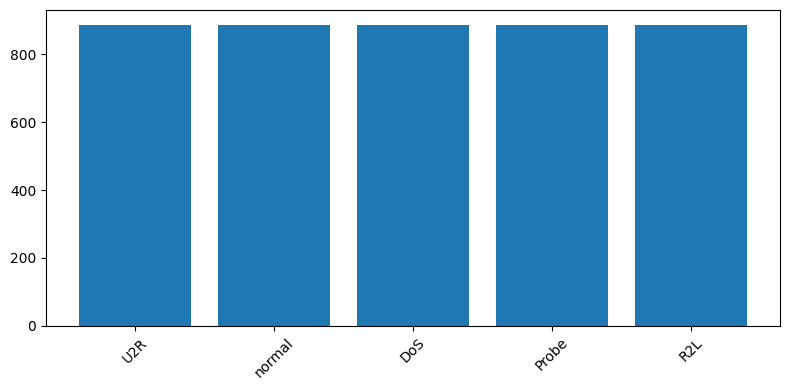

              precision    recall  f1-score   support

         DoS       0.16      0.18      0.17       177
       Probe       0.24      0.23      0.23       177
         R2L       0.22      0.24      0.23       177
         U2R       0.21      0.23      0.22       178
      normal       0.19      0.14      0.16       177

    accuracy                           0.20       886
   macro avg       0.20      0.20      0.20       886
weighted avg       0.20      0.20      0.20       886



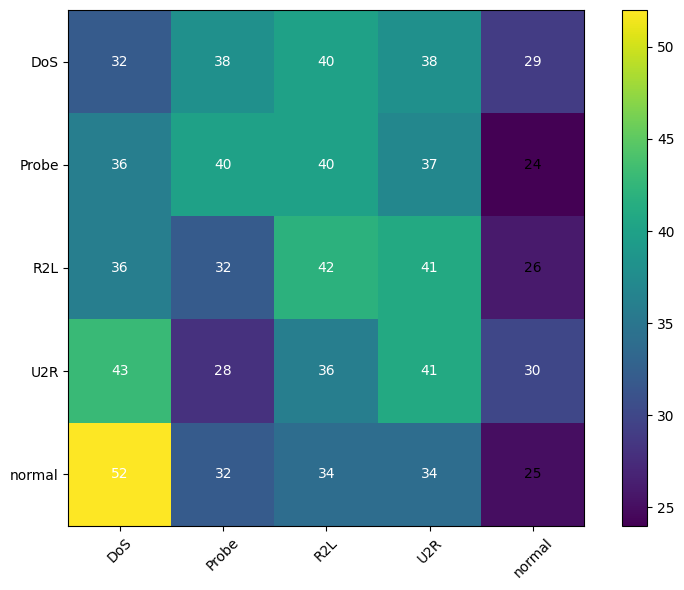

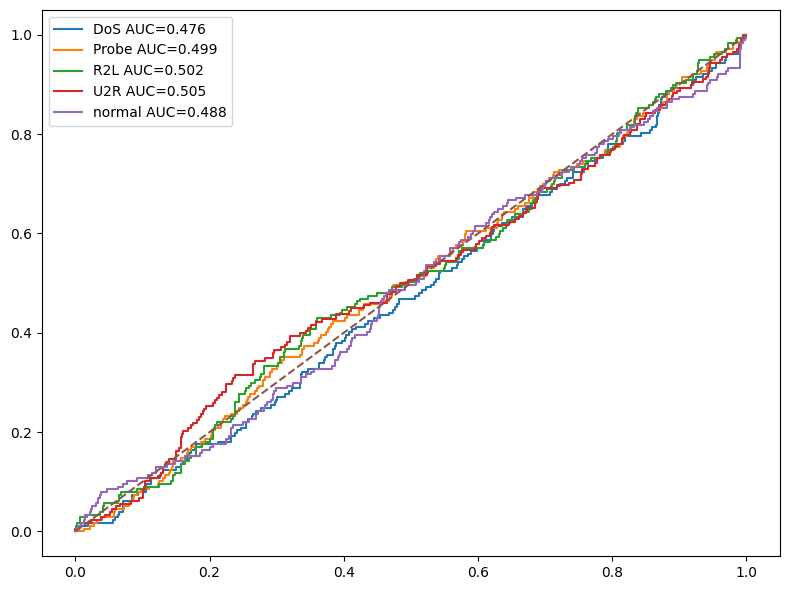

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      attack       0.80      1.00      0.89       709
      normal       0.00      0.00      0.00       177

    accuracy                           0.80       886
   macro avg       0.40      0.50      0.44       886
weighted avg       0.64      0.80      0.71       886



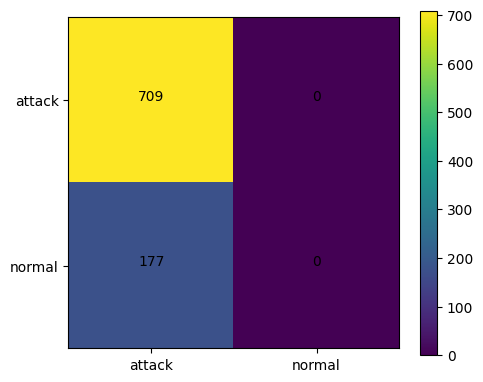

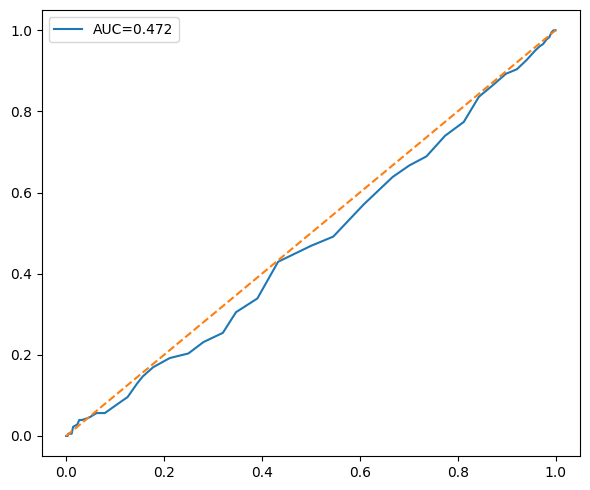

Saved models in /content/saved_models


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import joblib
import os

uploaded = files.upload()
file_name = list(uploaded.keys())[0] if len(uploaded) else "nsl_kdd_dataset.csv"
df = pd.read_csv(file_name)

label_col = None
for c in ['label', 'Label', 'LABEL']:
    if c in df.columns:
        label_col = c
        break
if label_col is None:
    raise KeyError("Label column not found")

if label_col != 'label':
    df.rename(columns={label_col: 'label'}, inplace=True)

y = df['label'].astype(str)
X = df.drop(columns=['label'])

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

plt.figure(figsize=(8,4))
vc = y.value_counts()
plt.bar(vc.index.astype(str), vc.values)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.20, random_state=42, stratify=y_enc
)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred_gnb = gnb.predict(X_test)
acc_gnb = accuracy_score(y_test, pred_gnb)

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced')
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred_rf)

best_model = rf if acc_rf >= acc_gnb else gnb
best_name = "RandomForest" if best_model is rf else "GaussianNB"

pred_best = best_model.predict(X_test)
print(classification_report(y_test, pred_best, target_names=class_names))

cm = confusion_matrix(y_test, pred_best)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, int(cm[i,j]), ha="center", va="center",
                 color="white" if cm[i,j] > cm.max()/2 else "black")
plt.tight_layout()
plt.show()

try:
    y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test)
    else:
        ovr = OneVsRestClassifier(best_model)
        ovr.fit(X_train, label_binarize(y_train, classes=np.arange(len(class_names))))
        y_score = ovr.predict_proba(X_test)

    fpr = {}; tpr = {}; roc_auc = {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8,6))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} AUC={roc_auc[i]:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.legend()
    plt.tight_layout()
    plt.show()
except:
    pass

y_binary = (y == 'normal').astype(int)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_scaled, y_binary.values, test_size=0.20, random_state=42, stratify=y_binary.values
)

gnb_b = GaussianNB()
gnb_b.fit(X_train_b, y_train_b)
pred_gnb_b = gnb_b.predict(X_test_b)
acc_gnb_b = accuracy_score(y_test_b, pred_gnb_b)

rf_b = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced')
rf_b.fit(X_train_b, y_train_b)
pred_rf_b = rf_b.predict(X_test_b)
acc_rf_b = accuracy_score(y_test_b, pred_rf_b)

best_bin = rf_b if acc_rf_b >= acc_gnb_b else gnb_b
best_bin_name = "RandomForest" if best_bin is rf_b else "GaussianNB"

print(classification_report(y_test_b, best_bin.predict(X_test_b), target_names=['attack','normal']))

cm_bin = confusion_matrix(y_test_b, best_bin.predict(X_test_b))
plt.figure(figsize=(5,4))
plt.imshow(cm_bin, interpolation='nearest')
plt.colorbar()
plt.xticks([0,1], ['attack','normal'])
plt.yticks([0,1], ['attack','normal'])
for i in range(cm_bin.shape[0]):
    for j in range(cm_bin.shape[1]):
        plt.text(j, i, cm_bin[i,j], ha="center")
plt.tight_layout()
plt.show()

if hasattr(best_bin, "predict_proba"):
    probs = best_bin.predict_proba(X_test_b)[:,1]
    fpr_b, tpr_b, _ = roc_curve(y_test_b, probs)
    roc_auc_b = auc(fpr_b, tpr_b)
    plt.figure(figsize=(6,5))
    plt.plot(fpr_b, tpr_b, label=f"AUC={roc_auc_b:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.legend()
    plt.tight_layout()
    plt.show()

model_dir = "/content/saved_models"
os.makedirs(model_dir, exist_ok=True)
joblib.dump(best_model, os.path.join(model_dir, f"best_multiclass_{best_name}.joblib"))
joblib.dump(best_bin, os.path.join(model_dir, f"best_binary_{best_bin_name}.joblib"))
joblib.dump(scaler, os.path.join(model_dir, "scaler.joblib"))
joblib.dump(le, os.path.join(model_dir, "label_encoder.joblib"))
print("Saved models in /content/saved_models")
